
# Cropped ROI Dataset Viewer (Notebook Version)

This notebook is the Jupyter adaptation of your interactive TIFF viewer:

- Uses **`%matplotlib widget`** (via `ipympl`) for live sliders in Jupyter.
- Uses **`tifffile`** to read `.tif/.tiff` (avoids the `imageio` dependency).
- Adds a **contrast RangeSlider** and an **image index Slider**.
- Includes a **scalebar** derived from your pixel size (px/µm).

> **Set `IMAGE_DIR` below** to your folder (default is your original path).


In [1]:

%matplotlib widget

import os, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RangeSlider
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tifffile import imread as tiff_imread


In [2]:

# ────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ────────────────────────────────────────────────────────────────────────
IMAGE_DIR = r"D:\Results\Interactive_figures\Cropped_ROI_dataset"

# Scale in pixels per micrometer
PX_PER_UM = 8.0453
# Scalebar length in micrometers
SCALER_LENGTH_UM = 1
# ────────────────────────────────────────────────────────────────────────
print("IMAGE_DIR =", IMAGE_DIR)


IMAGE_DIR = D:\Results\Interactive_figures\Cropped_ROI_dataset


In [3]:

def load_gray(path):
    img = tiff_imread(path)
    # If RGB or multi-channel, take first channel
    if img.ndim == 3:
        img = img[..., 0]
    return img


Found 10000 images.


0

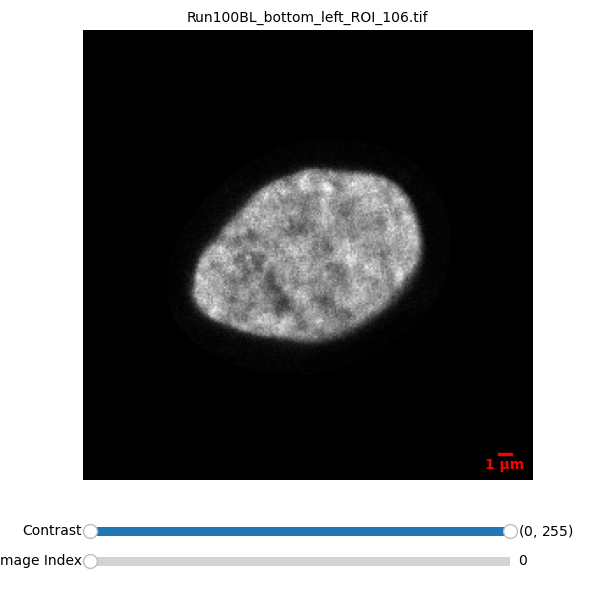

In [4]:

# 1) Collect all .tif/.tiff paths
paths = (
    sorted(glob.glob(os.path.join(IMAGE_DIR, "*.tif"))) +
    sorted(glob.glob(os.path.join(IMAGE_DIR, "*.tiff")))
)
n = len(paths)
if n == 0:
    raise RuntimeError(f"No TIFFs found in {IMAGE_DIR}")
print(f"Found {n} images.")

# 2) Load the first image
img = load_gray(paths[0])

# Determine a sensible intensity range
if np.issubdtype(img.dtype, np.integer):
    lo0, hi0 = 0, int(np.iinfo(img.dtype).max)  # supports 8/12/16-bit-in-16
else:
    lo0, hi0 = float(np.min(img)), float(np.max(img))

# 3) Set up figure & main axes
fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(bottom=0.20, top=0.95)
im = ax.imshow(img, cmap='gray', vmin=lo0, vmax=hi0)
ax.set_axis_off()
title = ax.set_title(os.path.basename(paths[0]), fontsize=10)

# 4) Add scalebar
bar_px = SCALER_LENGTH_UM * PX_PER_UM  # length in pixels
fontprops = fm.FontProperties(size=10, weight='bold')
scalebar = AnchoredSizeBar(ax.transData,
                           bar_px,
                           f"{SCALER_LENGTH_UM} μm",
                           loc='lower right',
                           pad=0.5,
                           color='red',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# 5) Contrast RangeSlider
contrast_ax = fig.add_axes([0.15, 0.10, 0.70, 0.03])
step = max(1, (hi0 - lo0) // 1024) if np.issubdtype(img.dtype, np.integer) else 0.0
contrast_slider = RangeSlider(
    ax=contrast_ax,
    label='Contrast',
    valmin=lo0,
    valmax=hi0,
    valinit=(lo0, hi0),
    valstep=step if step > 0 else None
)

def update_contrast(val):
    lo, hi = contrast_slider.val
    im.set_clim(lo, hi)
    fig.canvas.draw_idle()

contrast_slider.on_changed(update_contrast)

# 6) Image-Index Slider
idx_ax = fig.add_axes([0.15, 0.05, 0.70, 0.03])
idx_slider = Slider(
    ax=idx_ax,
    label='Image Index',
    valmin=0,
    valmax=n-1,
    valinit=0,
    valstep=1,
    valfmt='%0.0f'
)

def update_image(val):
    idx = int(idx_slider.val)
    new_img = load_gray(paths[idx])
    im.set_data(new_img)
    # Reapply current contrast limits
    lo, hi = contrast_slider.val
    im.set_clim(lo, hi)
    # Update title
    title.set_text(os.path.basename(paths[idx]))
    fig.canvas.draw_idle()

idx_slider.on_changed(update_image)



### Notes
- Ensure your environment has **ipympl** and **tifffile** installed.
- If widgets don't show, re-run the first cell to activate `%matplotlib widget`.


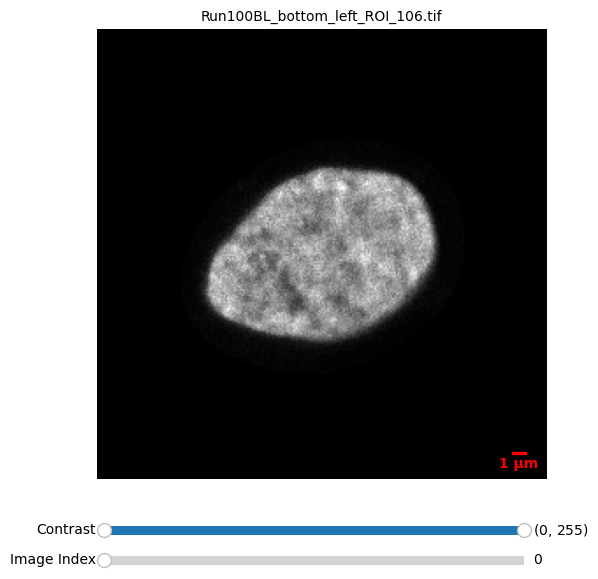

In [5]:
#| label: fig:cell-browser
fig  # show figure in notebook